In [1]:
import torch
import torchvision.models as models

# 加載預訓練的 DenseNet161 模型
model = models.densenet161()

# 定義兩個容器來保存 GAP 的輸入和輸出
gap_inputs = []
gap_outputs = []

def hook(module, input, output):
    # input 是一個包含單個元素的元組，因為前一層的輸出是這一層的輸入
    gap_inputs.append(input[0])  
    gap_outputs.append(output)

# 在 DenseNet 的 feature 模塊的最後進行 hook，假設 'norm5' 是最後的批量正規化層
# Global Average Pooling 層應該接在這個層之後
model.classifier.register_forward_hook(hook)

# 將模型設置為評估模式
model.eval()

# 創建一個隨機輸入張量
input_tensor = torch.randn(1, 3, 224, 224)

# 執行模型，觸發 hook
with torch.no_grad():
    model(input_tensor)

# 打印輸入和輸出的形狀
print("Shape of GAP input:", gap_inputs[-1].shape)
print("Shape of GAP output:", gap_outputs[-1].shape)


Shape of GAP input: torch.Size([1, 2208])
Shape of GAP output: torch.Size([1, 1000])


In [3]:
import torch.nn as nn
densenet161 = models.densenet161()
num_features = densenet161.classifier.in_features  # 2208
densenet161.classifier = nn.Sequential(
    # nn.BatchNorm1d(num_features),
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    # nn.Dropout(0.5),
    nn.Linear(512, 20),
)
densenet161

In [2]:
import torch
import torchvision.models as models

efficientnet_b7 = models.efficientnet_b7()
efficientnet_b7

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomDenseNet(nn.Module):
    def __init__(self, pretrained=True, num_classes=1000):
        super(CustomDenseNet, self).__init__()
        self.features = models.densenet161().features
        # self.reduction = nn.Conv2d(2208, 28, kernel_size=1, stride=1, padding=0)
        self.to_features = nn.Flatten(start_dim=2)
        self.attention = nn.MultiheadAttention(embed_dim=49, num_heads=1, dropout=0.1, batch_first=True)
        self.classifier = nn.Linear(49, 28)
        
    def forward(self, x):
        x = self.features(x)
        # x = self.reduction(x)
        x = self.to_features(x)
        x, _ = self.attention(x, x, x)
        # x = torch.mean(x, dim=2)
        x = self.classifier(x[:, -1, :])
        return x

In [7]:
model = CustomDenseNet()

# 假设有一个输入特征图
input_tensor = torch.randn(2, 3, 224, 224)

# 应用模型
output = model(input_tensor)

print(output.shape)
output[0]

torch.Size([2, 28])


tensor([ 0.1470, -0.0416, -0.0909, -0.1445, -0.0152, -0.0184,  0.0012,  0.1438,
         0.0082,  0.0562,  0.1307, -0.0604,  0.0366,  0.1048, -0.0967, -0.0588,
        -0.1046,  0.0560, -0.0370, -0.0381, -0.1067, -0.1522,  0.0074,  0.0159,
         0.0881,  0.0922,  0.0263, -0.1028], grad_fn=<SelectBackward0>)

In [42]:
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt

def fov_extractor(image):
    # Step 1: Convert to red channel and find image dimensions
    red_channel = image[:, :, 2]  # Assuming the image is in BGR format
    h, w = red_channel.shape

    # Step 2: Calculate center lines
    Hcenterline = h // 2
    Vcenterline = w // 2

    # Step 3: Draw scanning lines and calculate intensity profile
    horizontal_line = red_channel[Hcenterline, :]
    vertical_line = red_channel[:, Vcenterline]
    
    # Step 4: Calculate threshold using empirical factor
    th = max(horizontal_line) * 0.06

    # Find transitions based on threshold
    horizontal_transitions = np.where(np.diff(horizontal_line > th))[0]
    vertical_transitions = np.where(np.diff(vertical_line > th))[0]
    print(max(horizontal_line))
    print(np.where(np.diff(horizontal_line) > th))

    # Ensure there are at least two transitions to form a rectangle
    if len(horizontal_transitions) >= 2 and len(vertical_transitions) >= 2:
        X1, X2 = horizontal_transitions[[0, -1]]
        Y1, Y2 = vertical_transitions[[0, -1]]

        # Step 5: Crop the FOV based on found coordinates
        fov_image = image[Y1:Y2, X1:X2]
        return fov_image
    else:
        print("No valid transitions found")
        return None  # In case no valid transitions are found
    
# Load an image
image = cv2.imread("data/fundus/MuReD/images/images/10.png")
fov_image = fov_extractor(image)
# fov_image.show()
print(fov_image.shape)
cv2.imwrite("test.png", fov_image)

255
(array([   0,    1,    3,    7,    8,   11,   14,   20,   21,   22,   25,
         26,   29,   33,   37,   39,   40,   46,   55,   60,   84,   85,
         89,   90,   95,   97,  105,  106,  113,  114,  115,  116,  117,
        118,  123,  126,  127,  128,  129,  131,  132,  133,  134,  135,
        137,  138,  141,  142,  153,  158,  240,  245,  246,  247,  250,
        252,  257,  258,  259,  260,  261,  262,  263,  264,  265,  266,
        267,  268,  269,  271,  272,  274,  276,  277,  278,  284,  285,
        286,  292,  302,  303,  304,  305,  306,  309,  310,  313,  314,
        317,  321,  325,  328,  329,  336,  337,  340,  341,  342,  343,
        347,  348,  349,  352,  354,  355,  358,  359,  366,  367,  368,
        373,  376,  377,  381,  384,  385,  388,  390,  391,  398,  400,
        401,  406,  410,  411,  414,  417,  418,  420,  421,  434,  436,
        437,  438,  441,  444,  445,  446,  447,  456,  457,  462,  464,
        466,  467,  470,  472,  476,  477,  48

AttributeError: 'NoneType' object has no attribute 'shape'

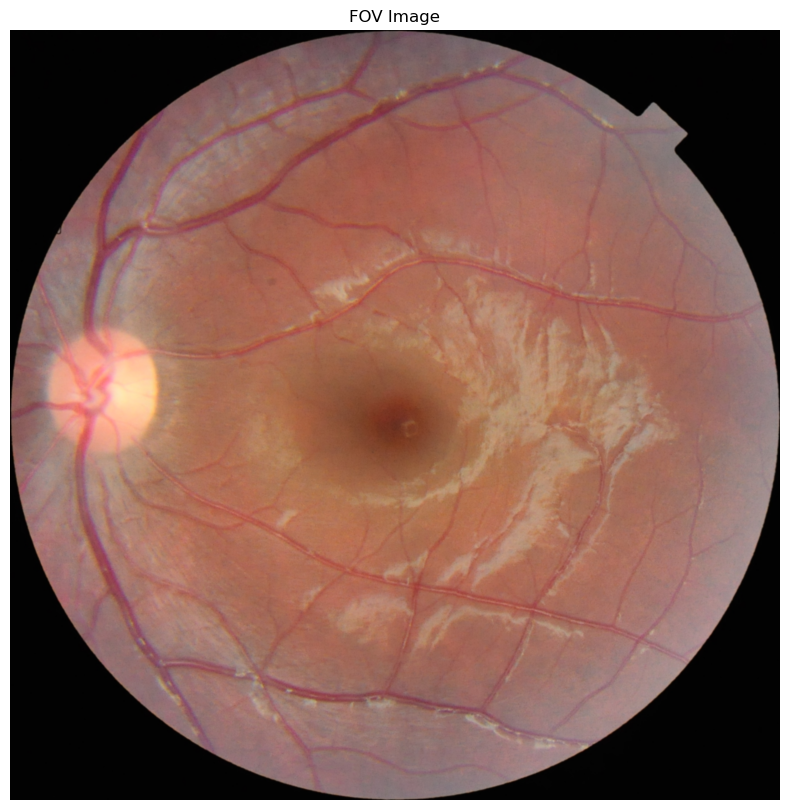

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def enhance_image(image, r, eps, enhancement_factor):
    image = image.astype(np.float32)
    # Apply guided filter to smooth the image
    smoothed = cv2.ximgproc.guidedFilter(guide=image, src=image, radius=r, eps=eps, dDepth=-1)
    # Calculate the detail image
    detail = image - smoothed
    # Enhance the image
    enhanced = smoothed + enhancement_factor * detail
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)
    return enhanced

def fov_extractor(image):
    # Method 1: Using contours
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # _, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    # contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # c = max(contours, key=cv2.contourArea)
    # mask = np.zeros_like(gray)
    # cv2.drawContours(mask, [c], -1, 255, thickness=cv2.FILLED)
    # result = cv2.bitwise_and(image, image, mask=mask)
    # result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    # return result
    
    # Method 2: Using intensity profile
    # Step 1: Convert to red channel and find image dimensions
    red_channel = image[:, :, 2]  # Assuming the image is in BGR format
    h, w = red_channel.shape

    # Step 2: Calculate center lines
    Hcenterline = h // 2
    Vcenterline = w // 2

    # Step 3: Draw scanning lines and calculate intensity profile
    horizontal_line = red_channel[Hcenterline, :]
    vertical_line = red_channel[:, Vcenterline]

    # Step 4: Calculate threshold using empirical factor
    th = max(horizontal_line) * 0.06

    # Find transitions based on threshold
    horizontal_transitions = np.where(np.diff(horizontal_line > th))[0]
    vertical_transitions = np.where(np.diff(vertical_line > th))[0]

    # Ensure there are at least two transitions to form a rectangle
    if len(horizontal_transitions) >= 2 and len(vertical_transitions) >= 2:
        X1, X2 = horizontal_transitions[[0, -1]]
        Y1, Y2 = vertical_transitions[[0, -1]]

        # Step 5: Crop the FOV based on found coordinates
        fov_image = image[Y1:Y2, X1:X2]
        return fov_image
    else:
        print("No valid transitions found")
        return None  # In case no valid transitions are found

# Load the image
image_path = 'data/fundus/RFMiD/Training_Set/Training/10.png'
image = cv2.imread(image_path)

# Parameters
radius = 20  # Radius of the window
epsilon = 0.01 * 255 * 255 # Regularization parameter
enhancement_factor = 5  # Factor to amplify details

# Enhance the image
# enhanced_image = enhance_image(image, radius, epsilon, enhancement_factor)

# Extract the FOV
fov_image = fov_extractor(image)

# Display images
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(fov_image, cv2.COLOR_BGR2RGB))
plt.title('FOV Image')
plt.axis('off')  # 不显示坐标轴
plt.show()


In [12]:
import cv2
import numpy as np
import os

def enhance_image(image, r, eps, enhancement_factor):
    image = image.astype(np.float32)
    smoothed = cv2.ximgproc.guidedFilter(guide=image, src=image, radius=r, eps=eps, dDepth=-1)
    detail = image - smoothed
    enhanced = smoothed + enhancement_factor * detail
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)
    return enhanced

def process_folder(source_folder, target_folder, r, eps, enhancement_factor):
    # 確保目標資料夾存在，若不存在則創建
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # 遍歷原始資料夾中的所有檔案
    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')):  # 確保是圖片檔案
            file_path = os.path.join(source_folder, filename)
            image = cv2.imread(file_path)

            if image is not None:
                # 對圖片進行增強處理
                enhanced_image = enhance_image(image, r, eps, enhancement_factor)
                # 構建保存路徑
                save_path = os.path.join(target_folder, filename)
                # 儲存增強後的圖片
                cv2.imwrite(save_path, enhanced_image)
                # print(f"Processed and saved: {save_path}")
            else:
                print(f"Failed to load image: {file_path}")

# 使用範例
source_folder = 'data/fundus/MuReD/images/images'
da_source_folder = 'data/fundus/MuReD/images/ros'
target_folder = 'data/fundus/MuReD/images/enhanced_ros'
r = 10  # 引導濾波半徑
eps = 0.1 * 255 * 255  # 正則化參數
enhancement_factor = 5  # 增強因子

process_folder(source_folder, target_folder, r, eps, enhancement_factor)
process_folder(da_source_folder, target_folder, r, eps, enhancement_factor)

In [2]:
import timm

model_names = timm.list_models('*convnextv2_large.*')
print(model_names)

[]


In [1]:
import timm

model_names = timm.list_models('*swinv2*')
print(model_names)

['swinv2_base_window8_256', 'swinv2_base_window12_192', 'swinv2_base_window12to16_192to256', 'swinv2_base_window12to24_192to384', 'swinv2_base_window16_256', 'swinv2_cr_base_224', 'swinv2_cr_base_384', 'swinv2_cr_base_ns_224', 'swinv2_cr_giant_224', 'swinv2_cr_giant_384', 'swinv2_cr_huge_224', 'swinv2_cr_huge_384', 'swinv2_cr_large_224', 'swinv2_cr_large_384', 'swinv2_cr_small_224', 'swinv2_cr_small_384', 'swinv2_cr_small_ns_224', 'swinv2_cr_small_ns_256', 'swinv2_cr_tiny_224', 'swinv2_cr_tiny_384', 'swinv2_cr_tiny_ns_224', 'swinv2_large_window12_192', 'swinv2_large_window12to16_192to256', 'swinv2_large_window12to24_192to384', 'swinv2_small_window8_256', 'swinv2_small_window16_256', 'swinv2_tiny_window8_256', 'swinv2_tiny_window16_256']


In [3]:
model = timm.create_model('convnextv2_large.fcmae_ft_in22k_in1k_384', pretrained=True, num_classes=0)
model

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): GlobalResponseNormMlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (grn): GlobalResponseNorm()
            (fc2): Linear(in_features=768, out_features=192, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), strid

In [5]:
features = []
for name, module in model.named_children():
    if 'stages' in name:
        for n, block in module.named_children():
            print(block)
# features

ConvNeXtStage(
  (downsample): Identity()
  (blocks): Sequential(
    (0): ConvNeXtBlock(
      (conv_dw): Conv2d(352, 352, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=352)
      (norm): LayerNorm((352,), eps=1e-06, elementwise_affine=True)
      (mlp): GlobalResponseNormMlp(
        (fc1): Linear(in_features=352, out_features=1408, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (grn): GlobalResponseNorm()
        (fc2): Linear(in_features=1408, out_features=352, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (shortcut): Identity()
      (drop_path): Identity()
    )
    (1): ConvNeXtBlock(
      (conv_dw): Conv2d(352, 352, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=352)
      (norm): LayerNorm((352,), eps=1e-06, elementwise_affine=True)
      (mlp): GlobalResponseNormMlp(
        (fc1): Linear(in_features=352, out_features=1408, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0